In [318]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma
from scipy.sparse import csr_matrix
from typing import List, Dict, Tuple, Set, Optional

In [389]:
def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

def init_variational_params(documents, K, rs_int=npr.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int)
    N, V = documents.shape
    LAMBDA = rs.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)
        
    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [368]:
def simulate_LDA(N, Ms, K, V, ETA, ALPHA, rs_int=np.random.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int) 
    BETA = rs.dirichlet(np.full(V, ETA), size=K)
    THETA = rs.dirichlet(np.full(K, ALPHA), size=N)
    
    row_idxs = []
    col_idxs = []
    values = []
    nonzero_idxs = []

    for i in range(N):
        doc_word_counts = np.zeros(V)
        for _ in range(Ms[i]):
            z_ij = rs.choice(K, p=THETA[i])
            x_ij = rs.choice(V, p=BETA[z_ij])
            doc_word_counts[x_ij] += 1
        doc_nonzero = np.nonzero(doc_word_counts)[0]
        doc_nonzero = np.array(sorted(doc_nonzero))
        nonzero_idxs.append(doc_nonzero)

        row_idxs.extend([i] * len(doc_nonzero))
        col_idxs.extend(doc_nonzero)
        values.extend(doc_word_counts[doc_nonzero])
    documents = csr_matrix((values, (row_idxs, col_idxs)), shape=(N, V)).toarray()
    
    return documents, nonzero_idxs, BETA, THETA

In [343]:
N = 100
avg_doc_length = 100
K = 10
V = 1000
ETA = 100 / V
ALPHA = 1 / K
documents, nonzero_idxs, BETA, THETA = simulate_LDA(N, avg_doc_length, K, V, ETA, ALPHA)
LAMBDA, GAMMA, PHI = init_variational_params(documents, K)

In [407]:
rs = npr.RandomState(0)
N = 10
K = 5
V = 100
Ms = rs.poisson(50, size=N)
eta0 = 0.3
alpha0 = 0.5
X, nonzero_idxs, _, _ = simulate_LDA(N, Ms, K, V, eta0, alpha0, rs_int=0)
lambd, gamma, phi = init_variational_params(X, K, rs_int=0)
E_log_q_z = 0
for i in range(N):
    document = documents[i]
    nonzero_idx = nonzero_idxs[i]
    word_idx = 0
    for idx in nonzero_idx:
        E_log_q_z += -document[idx] * np.sum(phi[i][word_idx] * np.log(phi[i][word_idx]))
        word_idx += 1
E_log_q_z

np.float64(41.84538572328661)

In [403]:
i = 0
document = documents[i]
nonzero_idx = nonzero_idxs[i]
idx = nonzero_idx[0]
document

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [394]:
N = 100
Ms = npr.poisson(100, size=N)
K = 10
V = 1000
ETA = 100 / V
ALPHA = 1 / K
documents, nonzero_idxs, BETA, THETA = simulate_LDA(N, Ms, K, V, ETA, ALPHA)
LAMBDA, GAMMA, PHI = init_variational_params(documents, K)

Initial ELBO: -72540.34410665429

Iteration 1


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 124.92it/s]


Current ELBO: -41547.50218562447 | Change in ELBO: 30992.841921029816

Iteration 2


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 163.85it/s]


Current ELBO: -40743.225261473446 | Change in ELBO: 804.276924151025

Iteration 3


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 174.72it/s]


Current ELBO: -39942.48506311362 | Change in ELBO: 800.7401983598247

Iteration 4


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 153.75it/s]


Current ELBO: -39126.80199397861 | Change in ELBO: 815.6830691350115

Iteration 5


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 158.00it/s]


Current ELBO: -38227.58342606864 | Change in ELBO: 899.2185679099712

Iteration 6


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.05it/s]


Current ELBO: -37271.48038395337 | Change in ELBO: 956.1030421152682

Iteration 7


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 162.09it/s]


Current ELBO: -36372.60904837147 | Change in ELBO: 898.8713355818982

Iteration 8


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 170.41it/s]


Current ELBO: -35654.66621713014 | Change in ELBO: 717.9428312413293

Iteration 9


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.79it/s]


Current ELBO: -35112.73657350458 | Change in ELBO: 541.9296436255609

Iteration 10


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 156.26it/s]


Current ELBO: -34707.56050212022 | Change in ELBO: 405.1760713843614

Iteration 11


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 144.21it/s]


Current ELBO: -34411.80639862886 | Change in ELBO: 295.7541034913593

Iteration 12


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.90it/s]


Current ELBO: -34202.78591661663 | Change in ELBO: 209.0204820122308

Iteration 13


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 158.43it/s]


Current ELBO: -34043.26781807223 | Change in ELBO: 159.51809854440216

Iteration 14


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 143.96it/s]


Current ELBO: -33924.83671815596 | Change in ELBO: 118.43109991626989

Iteration 15


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 150.54it/s]


Current ELBO: -33841.407849551484 | Change in ELBO: 83.4288686044747

Iteration 16


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 159.44it/s]


Current ELBO: -33781.23258425689 | Change in ELBO: 60.17526529459428

Iteration 17


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 160.27it/s]


Current ELBO: -33735.48754043211 | Change in ELBO: 45.74504382478335

Iteration 18


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.01it/s]


Current ELBO: -33700.856218936104 | Change in ELBO: 34.63132149600278

Iteration 19


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 163.65it/s]


Current ELBO: -33670.80429486375 | Change in ELBO: 30.05192407235154

Iteration 20


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 172.42it/s]


Current ELBO: -33647.08005176629 | Change in ELBO: 23.72424309746566

Iteration 21


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 161.03it/s]


Current ELBO: -33628.17411955052 | Change in ELBO: 18.905932215770008

Iteration 22


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 171.99it/s]


Current ELBO: -33610.70736493052 | Change in ELBO: 17.466754619999847

Iteration 23


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 169.51it/s]


Current ELBO: -33595.27793029727 | Change in ELBO: 15.429434633246274

Iteration 24


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 152.51it/s]


Current ELBO: -33582.19062561862 | Change in ELBO: 13.08730467865098

Iteration 25


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 173.89it/s]


Current ELBO: -33570.502200576906 | Change in ELBO: 11.688425041713344

Iteration 26


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 163.61it/s]


Current ELBO: -33559.3007873427 | Change in ELBO: 11.201413234208303

Iteration 27


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 165.20it/s]


Current ELBO: -33548.85457459355 | Change in ELBO: 10.446212749149709

Iteration 28


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 171.94it/s]


Current ELBO: -33540.779144245695 | Change in ELBO: 8.075430347853398

Iteration 29


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 172.72it/s]


Current ELBO: -33533.841517800494 | Change in ELBO: 6.937626445200294

Iteration 30


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 177.38it/s]


Current ELBO: -33527.31016679448 | Change in ELBO: 6.531351006015029

Iteration 31


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 175.73it/s]


Current ELBO: -33521.16792780126 | Change in ELBO: 6.142238993219507

Iteration 32


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 164.49it/s]


Current ELBO: -33515.73699531723 | Change in ELBO: 5.4309324840287445

Iteration 33


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.21it/s]


Current ELBO: -33511.77943784448 | Change in ELBO: 3.9575574727496132

Iteration 34


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 156.05it/s]


Current ELBO: -33509.062959996314 | Change in ELBO: 2.7164778481674148

Iteration 35


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 136.37it/s]


Current ELBO: -33506.503811717106 | Change in ELBO: 2.559148279207875

Iteration 36


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 156.98it/s]


Current ELBO: -33503.93940300826 | Change in ELBO: 2.5644087088439846

Iteration 37


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 154.78it/s]


Current ELBO: -33501.490337609146 | Change in ELBO: 2.44906539911608

Iteration 38


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 149.86it/s]


Current ELBO: -33499.26989238757 | Change in ELBO: 2.2204452215737547

Iteration 39


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 144.69it/s]


Current ELBO: -33497.81477807325 | Change in ELBO: 1.4551143143253285

Iteration 40


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 142.10it/s]


Current ELBO: -33496.94607190563 | Change in ELBO: 0.8687061676173471

Iteration 41


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 166.28it/s]


Current ELBO: -33495.80973893497 | Change in ELBO: 1.136332970658259

Iteration 42


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 163.22it/s]


Current ELBO: -33494.40810715968 | Change in ELBO: 1.4016317752902978

Iteration 43


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 170.80it/s]


Current ELBO: -33493.096447653916 | Change in ELBO: 1.3116595057654195

Iteration 44


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 178.58it/s]


Current ELBO: -33492.1299024619 | Change in ELBO: 0.9665451920154737

Iteration 45


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 175.41it/s]


Current ELBO: -33491.0265671088 | Change in ELBO: 1.1033353531020111

Iteration 46


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 183.00it/s]


Current ELBO: -33489.235405262174 | Change in ELBO: 1.7911618466241634

Iteration 47


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 180.21it/s]


Current ELBO: -33486.21321920954 | Change in ELBO: 3.0221860526362434

Iteration 48


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 175.53it/s]


Current ELBO: -33482.95264816515 | Change in ELBO: 3.2605710443895077

Iteration 49


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 155.82it/s]


Current ELBO: -33480.93726151285 | Change in ELBO: 2.0153866522960016

Iteration 50


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 177.33it/s]


Current ELBO: -33479.88103711535 | Change in ELBO: 1.0562243975000456

Iteration 51


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 91.78it/s]


Current ELBO: -33479.317094858896 | Change in ELBO: 0.5639422564563574

Iteration 52


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 174.99it/s]


Current ELBO: -33478.52236663858 | Change in ELBO: 0.794728220316756

Iteration 53


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 182.93it/s]


Current ELBO: -33477.4979276962 | Change in ELBO: 1.0244389423824032

Iteration 54


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.35it/s]


Current ELBO: -33476.88298212614 | Change in ELBO: 0.6149455700578983

Iteration 55


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 160.30it/s]


Current ELBO: -33476.276548730355 | Change in ELBO: 0.6064333957838244

Iteration 56


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 175.42it/s]


Current ELBO: -33475.440187528286 | Change in ELBO: 0.8363612020693836

Iteration 57


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 170.71it/s]


Current ELBO: -33474.58510979797 | Change in ELBO: 0.8550777303171344

Iteration 58


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 181.17it/s]


Current ELBO: -33473.857869411135 | Change in ELBO: 0.7272403868337278

Iteration 59


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 176.38it/s]


Current ELBO: -33473.51992352378 | Change in ELBO: 0.33794588735327125

Iteration 60


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 179.32it/s]


Current ELBO: -33473.23391991688 | Change in ELBO: 0.28600360690325033

Iteration 61


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 160.43it/s]


Current ELBO: -33472.82469921912 | Change in ELBO: 0.4092206977584283

Iteration 62


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 161.01it/s]


Current ELBO: -33472.222544707314 | Change in ELBO: 0.6021545118055656

Iteration 63


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 168.40it/s]


Current ELBO: -33471.601755485 | Change in ELBO: 0.6207892223173985

Iteration 64


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 180.35it/s]


Current ELBO: -33471.091126938365 | Change in ELBO: 0.5106285466317786

Iteration 65


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 175.94it/s]


Current ELBO: -33470.337031348776 | Change in ELBO: 0.7540955895892694

Iteration 66


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 178.31it/s]


Current ELBO: -33469.52609551743 | Change in ELBO: 0.8109358313449775

Iteration 67


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 176.83it/s]


Current ELBO: -33468.74134145765 | Change in ELBO: 0.784754059779516

Iteration 68


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 131.80it/s]


Current ELBO: -33468.47363726239 | Change in ELBO: 0.26770419526292244

Iteration 69


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 180.03it/s]


Current ELBO: -33468.32922464969 | Change in ELBO: 0.14441261269530514

Iteration 70


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 180.45it/s]


Current ELBO: -33468.093168483356 | Change in ELBO: 0.23605616633722093

Iteration 71


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 171.01it/s]


Current ELBO: -33467.68019584005 | Change in ELBO: 0.41297264330933103

Iteration 72


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 182.21it/s]


Current ELBO: -33467.29898889714 | Change in ELBO: 0.3812069429041003

Iteration 73


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 176.89it/s]


Current ELBO: -33467.13327957904 | Change in ELBO: 0.16570931810565526

Iteration 74


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 180.58it/s]


Current ELBO: -33466.910804918814 | Change in ELBO: 0.2224746602223604

Iteration 75


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 179.31it/s]


Current ELBO: -33466.561937540915 | Change in ELBO: 0.3488673778992961

Iteration 76


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 184.51it/s]


Current ELBO: -33465.977708904014 | Change in ELBO: 0.5842286369006615

Iteration 77


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 173.94it/s]


Current ELBO: -33465.09622603061 | Change in ELBO: 0.8814828734030016

Iteration 78


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 171.80it/s]


Current ELBO: -33464.43081016677 | Change in ELBO: 0.66541586384119

Iteration 79


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 182.27it/s]


Current ELBO: -33463.967355825094 | Change in ELBO: 0.46345434167596977

Iteration 80


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 177.37it/s]


Current ELBO: -33463.68484190566 | Change in ELBO: 0.28251391943194903

Iteration 81


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 181.65it/s]


Current ELBO: -33463.238924492165 | Change in ELBO: 0.44591741349722724

Iteration 82


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 172.20it/s]


Current ELBO: -33462.60158684854 | Change in ELBO: 0.6373376436240505

Iteration 83


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 134.90it/s]


Current ELBO: -33462.21085430265 | Change in ELBO: 0.39073254589311546

Iteration 84


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 151.67it/s]


Current ELBO: -33462.138160811985 | Change in ELBO: 0.07269349066336872

Iteration 85


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 164.29it/s]


Current ELBO: -33462.12317939127 | Change in ELBO: 0.014981420717958827

Iteration 86


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 159.72it/s]


Current ELBO: -33462.09469036624 | Change in ELBO: 0.028489025025919545

Iteration 87


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 141.89it/s]


Current ELBO: -33462.04761996945 | Change in ELBO: 0.047070396787603386

Iteration 88


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 138.87it/s]


Current ELBO: -33461.97111010961 | Change in ELBO: 0.07650985984219005

Iteration 89


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.95it/s]


Current ELBO: -33461.84196797116 | Change in ELBO: 0.12914213845215272

Iteration 90


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 157.44it/s]


Current ELBO: -33461.610517006426 | Change in ELBO: 0.23145096473308513

Iteration 91


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 146.83it/s]


Current ELBO: -33461.22791950141 | Change in ELBO: 0.3825975050131092

Iteration 92


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 166.08it/s]


Current ELBO: -33461.013421021 | Change in ELBO: 0.21449848041083897

Iteration 93


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 152.18it/s]


Current ELBO: -33461.00830114281 | Change in ELBO: 0.005119878194818739

Iteration 94


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 149.39it/s]


Current ELBO: -33461.00721330282 | Change in ELBO: 0.001087839984393213

Iteration 95


Updating LAMBDA: 100%|██████████| 10/10 [00:00<00:00, 137.04it/s]


Current ELBO: -33461.006264998025 | Change in ELBO: 0.0009483047979301773



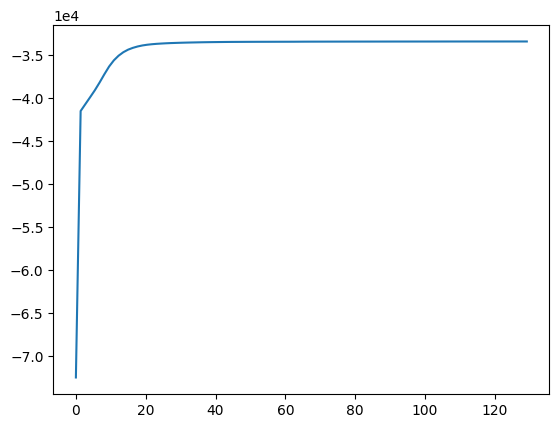

In [395]:
start = time.time()
ELBOs = []
prev_ELBO = -np.inf
curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K)
ELBOs.append(curr_ELBO)
print(f"Initial ELBO: {ELBOs[0]}\n")

max_iterations = 200
tol = 10e-4
LAMBDA_t = copy.deepcopy(LAMBDA)
GAMMA_t = copy.deepcopy(GAMMA)
PHI_t = copy.deepcopy(PHI)

for t in range(max_iterations):
    print(f"Iteration {t+1}")
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        GAMMA_i_t = copy.deepcopy(GAMMA_t[i])
        word_idx = 0
        for idx in nonzero_idx:
            log_PHI_ij = np.zeros((K,))
            for k in range(K):
                LAMBDA_k_t = copy.deepcopy(LAMBDA_t[k])
                exp_propto = digamma(GAMMA_i_t[k]) - digamma(np.sum(GAMMA_i_t)) + digamma(LAMBDA_k_t[idx]) - digamma(np.sum(LAMBDA_k_t))
                log_PHI_ij[k] = exp_propto
            PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
            PHI_t[i][word_idx] = PHI_ij
            word_idx += 1
        GAMMA_i_t = np.zeros((K,)) + ALPHA
        for k in range(K):
            GAMMA_i_t[k] += np.sum(document[nonzero_idx] * PHI_t[i][:, k])
        GAMMA_t[i] = GAMMA_i_t

    for k in tqdm(range(K), desc="Updating LAMBDA"):
        LAMBDA_k_t = np.zeros((V,)) + ETA
        for i in range(N):
            document = documents[i]
            nonzero_idx = nonzero_idxs[i]
            word_idx = 0
            for idx in nonzero_idx:
                LAMBDA_k_t[idx] += document[idx] * PHI_t[i][word_idx][k]
                word_idx += 1
            LAMBDA_t[k] = LAMBDA_k_t

    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA_t, GAMMA_t, PHI_t, documents, nonzero_idxs, K)
    ELBOs.append(curr_ELBO)
    print(f"Current ELBO: {curr_ELBO} | Change in ELBO: {curr_ELBO - prev_ELBO}\n")

    if abs(curr_ELBO - prev_ELBO) < tol:
        break
stop = time.time()

LAMBDA_final = copy.deepcopy(LAMBDA_t)
GAMMA_final = copy.deepcopy(GAMMA_t)
PHI_final = copy.deepcopy(PHI_t)

plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, stop-start, len(ELBOs)), ELBOs)

In [366]:
scipy.stats.mode(GAMMA_final)[0], ALPHA

(array([0.10000286, 0.10000229, 0.1       , 0.10000247, 0.100003  ,
        0.10000081, 0.10000016, 0.10000192, 0.10000794, 0.10000294]),
 0.1)

In [367]:
LAMBDA_final

array([[ 0.1       ,  0.1000267 ,  0.10002263, ...,  0.100028  ,
         0.10006777,  1.41097701],
       [ 0.1       ,  0.10003144,  8.77373138, ...,  0.10003149,
         0.10003141,  0.10000953],
       [ 0.1       , 15.90248326,  0.10003523, ...,  0.10002982,
         0.10006223,  0.10002945],
       ...,
       [ 0.1       ,  0.10002337,  0.10003085, ...,  0.1000044 ,
         2.09938016,  0.10001498],
       [ 0.1       , 11.65706117,  4.42604876, ...,  0.10002072,
         0.10004937,  0.1001824 ],
       [ 0.1       ,  0.10002198,  0.10003271, ...,  0.10000657,
         0.10001766,  2.78857486]])